# Notebook for subtype analysis on gait and rs-fMRI brain connectivity data 
This notebook walks through the data analysis for our data-driven subtyping approach using video-captured human motion and brain fMRI data.

<i> Note: this notebook was run on FC data and clinical test scores that are unable to be shared publically. To demo the code on a simulated dataset, visit [this notebook](demo_analyze_subtypes.ipynb).</i>

## Imports

In [1]:
from utils.data_loading import load_data
from utils.subtypes import get_subtypes, find_subtype_clinical_characteristics
from utils.plots import visualize_motion_fc_characteristics, visualize_motion_fc_characteristics_boxplot, create_per_patient_plot_categorical, create_per_patient_plot_numerical, create_hist_random_wcss_scores
from utils.metrics import wcss_score

import random
import numpy as np
from scipy.special import softmax
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

## Directories

In [2]:
clinical_data_path = '../data/private_data/clinical_data.csv'
gait_scores_path = '../data/private_data/gait_scores.csv'
motion_encoder_dir = '../data/private_data/motion_encoder_outputs/'
fc_matrices_dir = '../data/private_data/fc_matrices/'

## Run subtyping approach

In [3]:
clinical_data, fmri_data, motion_encoder_outputs, fmri_corresponding_outputs, person_samples_start_ends = load_data(clinical_data_path, gait_scores_path, motion_encoder_dir, fc_matrices_dir)

/deep/u/markendo/anaconda3/envs/delete_later/lib/python3.7/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [4]:
clinical_data_per_clip, cca_features = get_subtypes(clinical_data, fmri_data, motion_encoder_outputs, fmri_corresponding_outputs, person_samples_start_ends)
clinical_data = clinical_data_per_clip.drop_duplicates(subset=['PID']).copy() # include subtypes in clinical data

## Motion-FC subtypes

We can study the characteristics of the resulting subtypes by identifying clinical variables that exhibit significantly different expression levels across subtypes

In [5]:
significant_clinical_variables, significant_clinical_variables_p_values = find_subtype_clinical_characteristics(clinical_data)

We can then visualize these clinical variables

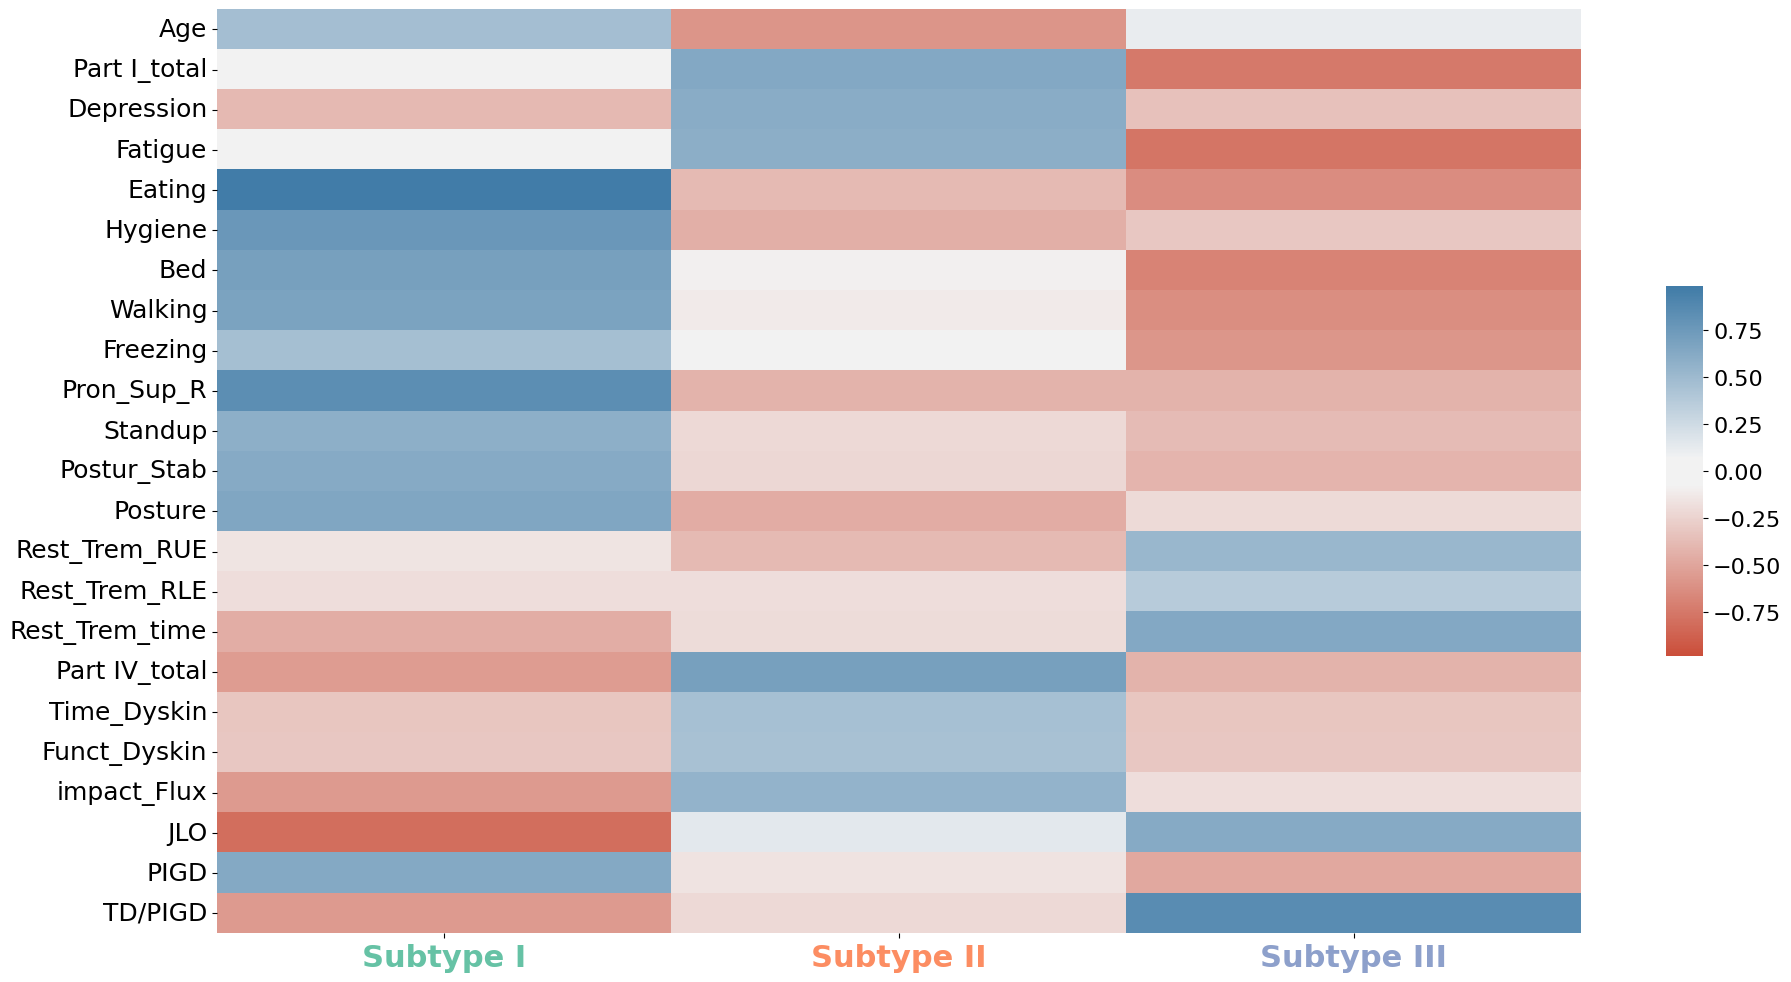

In [6]:
fig = visualize_motion_fc_characteristics(clinical_data, significant_clinical_variables)

For a more in-depth visualization, we can use a box and whisker plot for each clinical variable

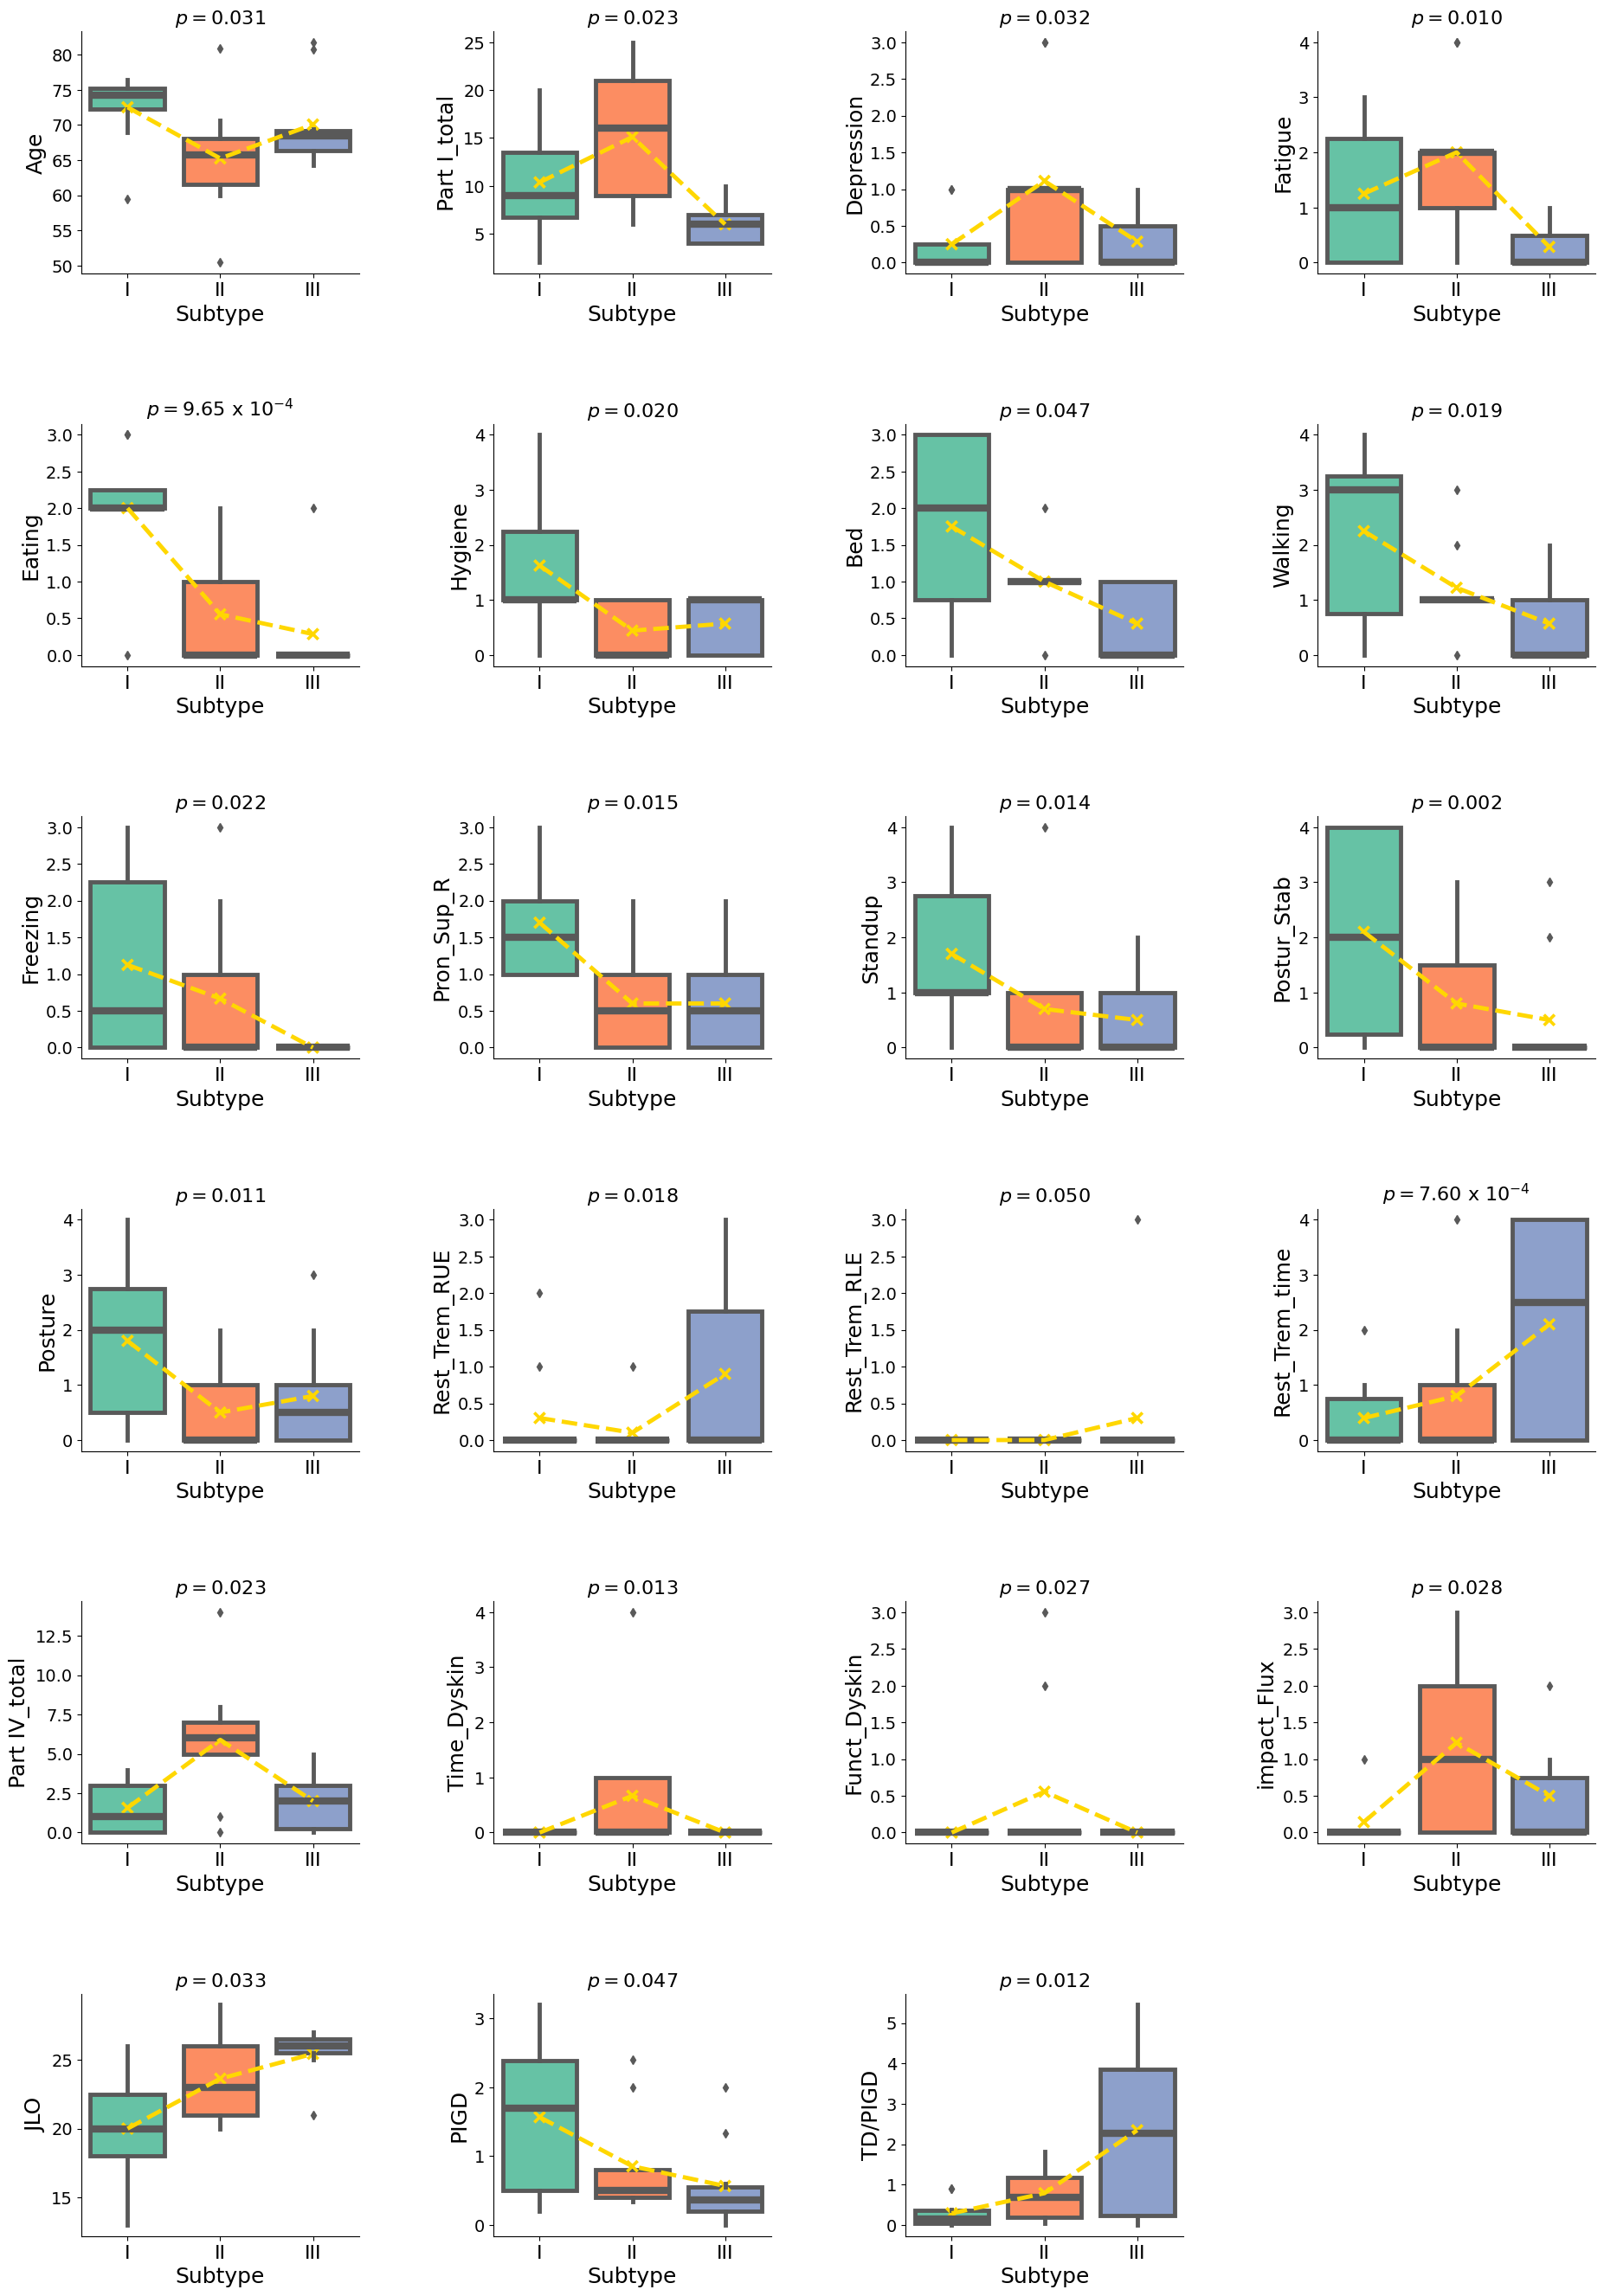

In [7]:
fig = visualize_motion_fc_characteristics_boxplot(clinical_data, significant_clinical_variables, significant_clinical_variables_p_values)

## Visualize subtypes

We first visualize our subtype clustering. CCX signifies the motion component and CCY signifies the fMRI component. For CCX, each oval represents an individual as there are multiple motion features corresponding to each individual from sampling fixed size clips from the gait examinations.

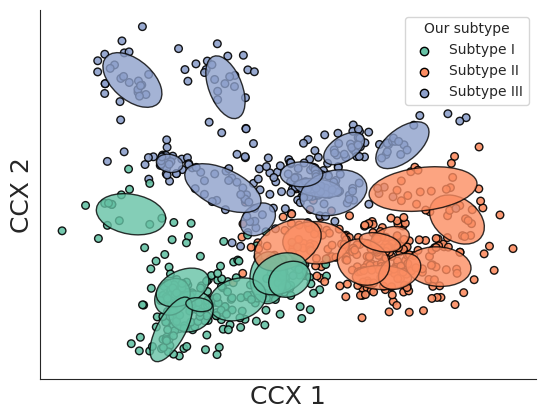

In [8]:
sns.set_style("white")

plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

subtype_colorpalette = ["#66c2a5", "#fc8d62", "#8da0cb"]

ax = create_per_patient_plot_categorical(x='CCX_1', y='CCX_2', hue='Our subtype', data=clinical_data_per_clip, hue_order=[0, 1, 2], person_bounds=person_samples_start_ends, palette=subtype_colorpalette)

legend_labels = ['Subtype I', 'Subtype II', 'Subtype III']
legend = ax.legend(handles=ax.get_legend_handles_labels()[0], labels=legend_labels, title='Our subtype')

for handle in ax.get_legend().legendHandles:
    handle.set_edgecolor('black')
    handle.set_linewidth(1)
    
sns.despine(ax=ax)
ax.set_xlabel('CCX 1')
ax.xaxis.label.set_size(18)
ax.set_ylabel('CCX 2')
ax.yaxis.label.set_size(18)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

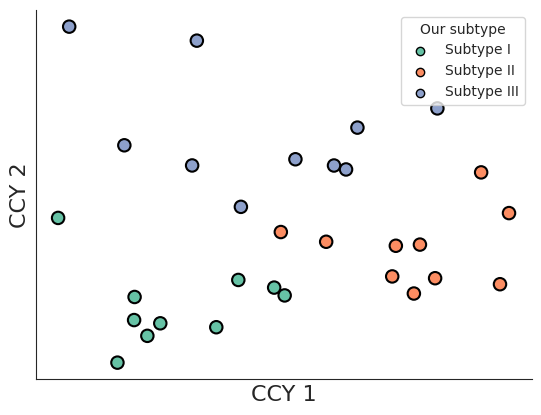

In [9]:
ax = sns.scatterplot(x='CCY_1', y='CCY_2', data=clinical_data, hue='Our subtype', palette=subtype_colorpalette, hue_order=[0, 1, 2], s=80, edgecolor='black', linewidth=1.5)


legend_labels = ['Subtype I', 'Subtype II', 'Subtype III']
legend = ax.legend(handles=ax.get_legend_handles_labels()[0], labels=legend_labels, title='Our subtype')

for handle in ax.get_legend().legendHandles:
    handle.set_edgecolor('black')
    handle.set_linewidth(1)

sns.despine(ax=ax)
ax.set_xlabel('CCY 1')
ax.xaxis.label.set_size(16)
ax.set_ylabel('CCY 2')
ax.yaxis.label.set_size(16)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

We can also visualize how well other subtyping approaches are clustered in our subtyping space. Here, we will visualize TD/PIGD subtypes and clinical variable subtypes in our subtyping space.

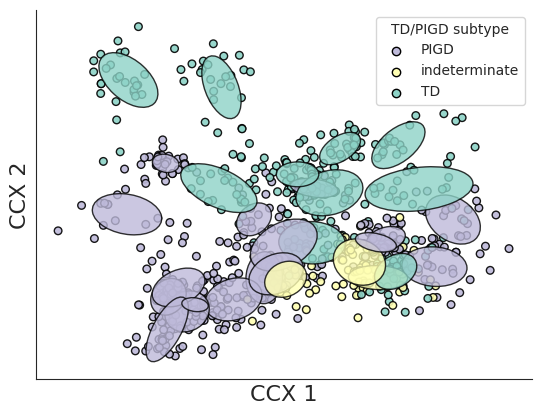

In [10]:
td_pigd_color_pallete = ['#bebada', '#ffffb3', '#8dd3c7']

ax = create_per_patient_plot_categorical(x='CCX_1', y='CCX_2', hue='TD/PIGD subtype', data=clinical_data_per_clip, hue_order=['PIGD', 'indeterminate', 'TD'], person_bounds=person_samples_start_ends, palette=td_pigd_color_pallete, alpha=0.9)

for handle in ax.get_legend().legendHandles:
    handle.set_edgecolor('black')
    handle.set_linewidth(1)

sns.despine(ax=ax)
ax.set_xlabel('CCX 1')
ax.xaxis.label.set_size(16)
ax.set_ylabel('CCX 2')
ax.yaxis.label.set_size(16)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

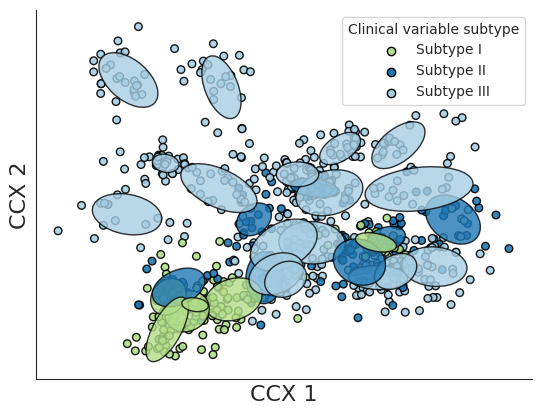

In [11]:
clinical_subtype_pallete = ['#b2df8a', '#1f78b4', '#a6cee3']

ax = create_per_patient_plot_categorical(x='CCX_1', y='CCX_2', hue='Clinical variable subtype', data=clinical_data_per_clip, hue_order=[2, 0, 1], person_bounds=person_samples_start_ends, palette=clinical_subtype_pallete)

legend_labels = ['Subtype I', 'Subtype II', 'Subtype III']
legend = ax.legend(handles=ax.get_legend_handles_labels()[0], labels=legend_labels, title='Clinical variable subtype')

for handle in ax.get_legend().legendHandles:
    handle.set_edgecolor('black')
    handle.set_linewidth(1)

sns.despine(ax=ax)
ax.set_xlabel('CCX 1')
ax.xaxis.label.set_size(16)
ax.set_ylabel('CCX 2')
ax.yaxis.label.set_size(16)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

Lastly, we can visualize the clustering scores for random cohort groupings in our representation space

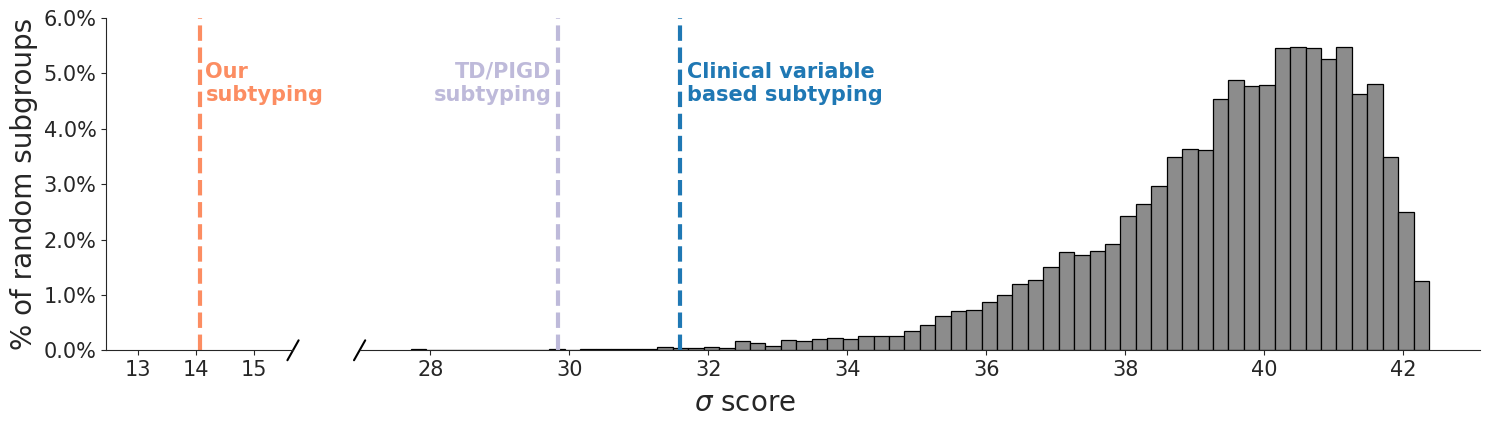

In [12]:
our_approach_score_wcss = wcss_score(clinical_data['Our subtype'], cca_features)
conventional_approach_score_wcss = wcss_score(clinical_data['Clinical variable subtype'], cca_features)
td_pigd_approach_score_wcss = wcss_score(clinical_data['TD/PIGD subtype'], cca_features)


# randomly assign likelyhood person is assigned to a group
random_group_weights = [random.uniform(0, 1) for i in range(3)]
random_group_weights = softmax(random_group_weights)

# assign groups
random_group_labels = []
n = 10000
for random_iter in range(n):
    random_group_label = []
    for i in range(np.shape(cca_features)[0]):
        random_group_label.append(np.random.choice([0, 1, 2], p=random_group_weights))
    random_group_labels.append(random_group_label)

# calculate random scores
random_groups_wcss_scores = []
for random_group_label in random_group_labels:
    random_groups_wcss_scores.append(wcss_score(random_group_label, cca_features))

    
fig = create_hist_random_wcss_scores(random_groups_wcss_scores, our_approach_score_wcss, conventional_approach_score_wcss, td_pigd_approach_score_wcss)
plt.show()